In [22]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, execute, assemble, transpile, Aer, IBMQ
from qiskit.visualization import *
from qiskit.circuit import Parameter
from qiskit.providers.aer import AerSimulator

# Numpy and Scipy for data evaluation and reference calculations
import numpy as np
from scipy.linalg import expm
# Matplotlib for visualization
import matplotlib.pyplot as plt
# Magic function to render plots in the notebook after the cell executing the plot command
%matplotlib inline

In [31]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
def Op(M, n ,N):
    """Given a single site operator, provide the N-body operator 
    string obtained by tensoring identities"""
    d = M.shape[0]
    id_left = np.eye(d**n)
    id_right = np.eye(d**(N-n-1))
    res = np.kron(id_left,np.kron(M,id_right))
    return res

def IsingHamiltonian(N, h):
    """The Ising Hamiltonian for N sites with parameter h"""
    Z = np.array([[1., 0.],[0., -1.]])
    X = np.array([[0., 1.],[1., 0.]])
    H = np.zeros((2**N, 2**N))
    for i in range(N):
        if i<N-1:            
            H += Op(Z, i, N)@Op(Z, i+1, N)
        H += h*Op(X, i, N)
    return H            

# For reference, we provide a function computing the exact solution for
# the magnetization as a function of time
# initialstate is a string defining the binary number to start with
def get_magnetization_vs_time(h, timestep, nsteps, nqubits,initialstate):
    """Compute the exact value of the magnetization"""
    Z = np.array([[1., 0.],[0., -1.]])
    X = np.array([[0., 1.],[1., 0.]])
    Id = np.eye(2)
    # The Ising Hamiltonian for N sites with parameter h
    H = IsingHamiltonian(nqubits, h)
    # The time evolution operator for an interval \Delta t
    U = expm(-1.0j*timestep*H)
    # The operator for the total magnetization
    M = np.zeros((2**nqubits,2**nqubits))
    for iq in range(nqubits):
        M += Op(Z,iq,nqubits)
    # Numpy array to hold the results
    magnetization = np.zeros(nsteps)
    # The initial wave function corresponding to |0010>
    psi = np.zeros(2**nqubits)
    psi[int(initialstate, 2)] = 1
    # Evolve in steps of \Delta t and measure the magnetization
    for n in range(nsteps):
        psi = U@psi
        magnetization[n] = np.real(psi.conj().T@M@psi)
    return magnetization

In [4]:
# Only handling product states
def provide_initial_state(qc,initial_state):
    # Add the necessary gate(s) to provide the inital state |0010>
    for iq,qubit in enumerate(reversed(list(initial_state))):
        if int(qubit):
            qc.x(iq)
    
    return qc

def add_Uzz(qc, delta_t):
    # Add the gates for exp(-i Z_k Z_k+1 \Delta t) for all neighboring qubits
    for iq in range(qc.num_qubits-1):
        qc.rzz(2*delta_t,iq,iq+1)
    
    return qc

def add_Ux(qc, delta_t, h):
    # Add the gates for exp(-i h X_k \Delta t) to all qubits
    for iq in range(qc.num_qubits):
        qc.rx(2*delta_t*h,iq) # RX(theta) = exp(-i theta X/2)
    
    return qc

def define_timestep(qc, delta_t, h):
    qc_deltat = QuantumCircuit(qc.num_qubits)
    add_Uzz(qc_deltat,delta_t)
    add_Ux(qc_deltat,delta_t,h)
    return qc_deltat

def build_time_evolution_circuit(initial_state, h, delta_t_param, nsteps, nqubits):
    """Build the circuit evolving the wave function by some time interval delta_t
    from the circuits implementing the initial state and the two parts
    of the trotterized time-evolution operator 
    """
    # Generate an empty quantum circuit qc for 4 qubits
    qc = QuantumCircuit(nqubits)

    # Add the inital state
    provide_initial_state(qc,initial_state)

    # Add one iteration of H for each timestep
    qc_deltat = define_timestep(qc,delta_t_param,h)
    for i in range(nsteps):
        qc.compose(qc_deltat,inplace=True)

    # Add the final measurements
    qc.measure_all()
    return qc

In [5]:
def get_magnetization(counts,nqubits):
    """Given the counts resulting form a measurement, compute the site
    resolved magnetization"""
    total_counts = sum(counts.values())
    res = np.zeros(nqubits)
    for qubit in range(nqubits):
        Z_expectation = 0.
        for key, value in counts.items():
            if key[qubit] == '0':
                Z_expectation += value
            else:
                Z_expectation -= value
        res[qubit] = Z_expectation/total_counts
    return res

In [6]:
# The parameters for the time evolution
h = 1
timestep = 0.05
nsteps = 100
nshots = 1000
nqubits = 4
initial_state = "0010"

In [7]:
from qiskit.test.mock import FakeVigo

def get_backend(do_noise=False):
    if do_noise:
        return FakeVigo()
    else:
        return Aer.get_backend('qasm_simulator')
    
def run_circuit(qc_bound,num_shots,backend):
    job = execute(qc_bound, backend=backend, shots=num_shots)
    result = job.result()
    return result

In [8]:
def simulate_time_evolution(h,timestep,nsteps,nshots,nqubits,initial_state,do_noise):
    # Numpy array for expectation values of the magnetization
    magnetization = np.zeros(nsteps)
    # Numpy array for qubit configuration
    configuration = np.zeros((nqubits, nsteps))
    # Build the parameterised time evolution circuit
    delta_t = Parameter('delta_t')

    # Run the evolution circuit on the qasm_simulator
    results_per_step = []
    for n in range(1, nsteps+1):
        delta_t_val = {delta_t:timestep}
        qc_evo = build_time_evolution_circuit(initial_state, h, delta_t, n, nqubits)
        backend=get_backend(do_noise)
        qc_transpiled = transpile(qc_evo,backend=backend)
        qc_bound = qc_transpiled.bind_parameters(delta_t_val)
        results_per_step.append(run_circuit(qc_bound,nshots,backend))
    return results_per_step

def get_magnetization_with_solution(h, timestep, nsteps, nqubits, initial_state, counts_per_step):
    magnetization = np.zeros(nsteps)
    configuration = np.zeros((nqubits, nsteps))

    for n in range(nsteps):
        # Compute the observables
        configuration[:,n] = get_magnetization(counts_per_step[n],nqubits)
        magnetization[n] = sum(configuration[:,n])
    # For reference we compute the exact solution
    magnetization_exact = get_magnetization_vs_time(h, timestep, nsteps, nqubits, initial_state)
    return magnetization, magnetization_exact, configuration

In [34]:
colours = ['r','g','b','gold','indigo','dodgerblue','dimgrey']
def plot_magnetization(mag_vs_h,draw_configuration=True):
    # Plot the total magnetization as a function of time and compare to
    # the exact result
    plt.figure()
    for ih,h in enumerate(fieldstrengths):
        magnetization, magnetization_exact, configuration = mag_vs_h[h]
        plt.plot(magnetization_exact, '--', label=f'exact ({h})',color=colours[ih])
        plt.plot(magnetization, 'o', label=f'quantum circuit ({h})',color=colours[ih])
    plt.xlabel('$t/\Delta t$')
    plt.ylabel('$<\sum_i Z_i(t)>$')
    plt.title('Total magnetization')
    plt.legend(loc='lower right')

    if draw_configuration:
        for ih,h in enumerate(fieldstrengths):
            magnetization, magnetization_exact, configuration = mag_vs_h[h]

            # Plot the site resolved spin configuration as a function of time
            plt.figure()
            plt.imshow(configuration, aspect='auto')
            plt.colorbar()
            plt.xlabel('$t/\Delta t$')
            plt.ylabel('$<Z_i(t)>$')
            plt.title(f'Spatially resolved spin configuration ({h})')

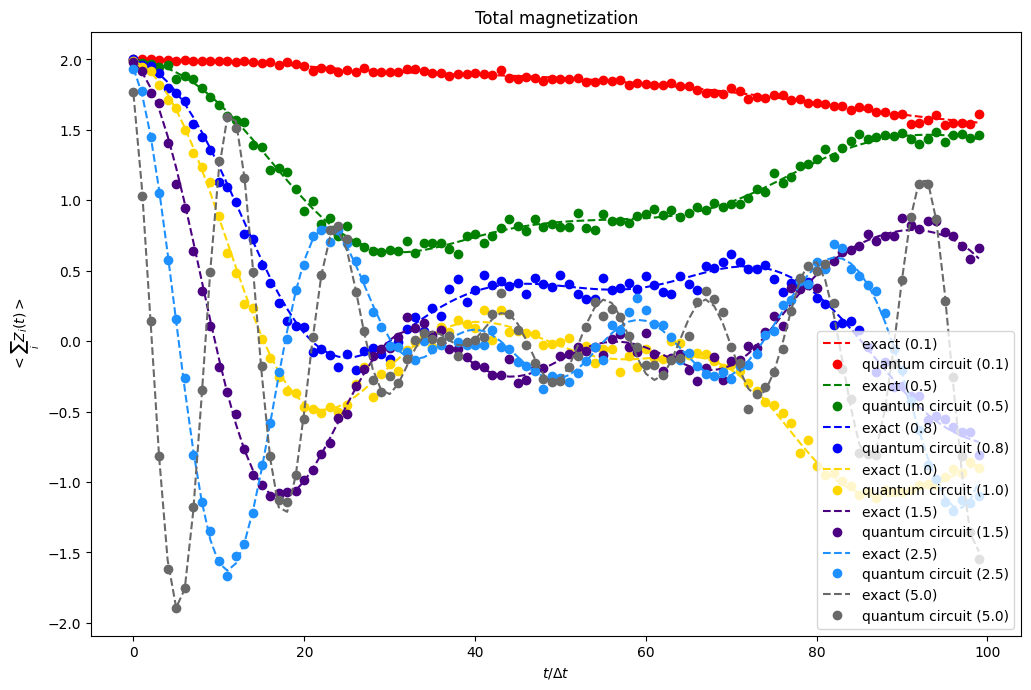

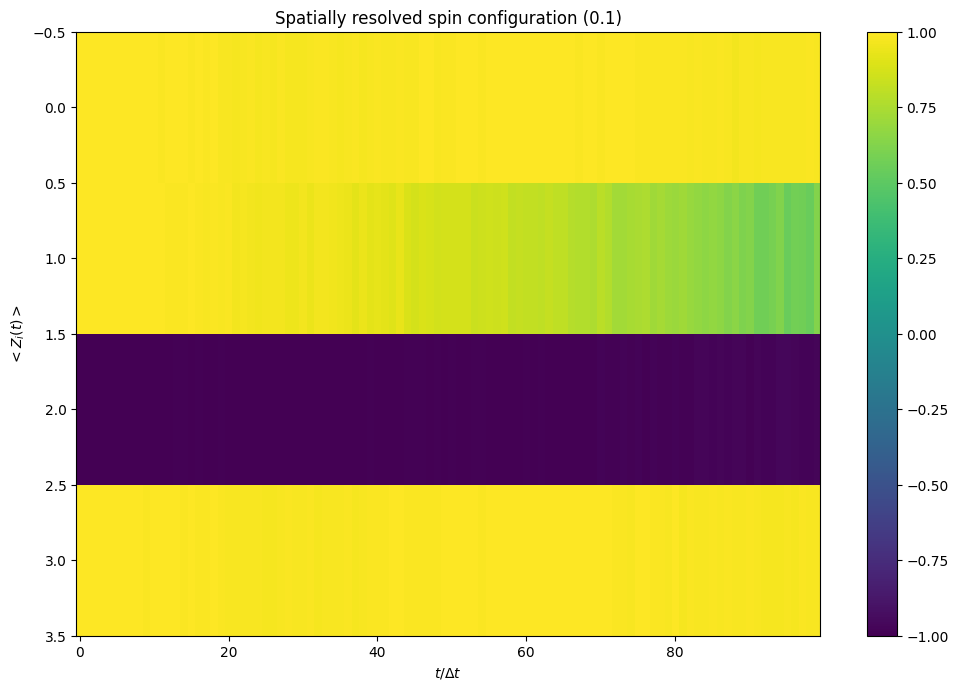

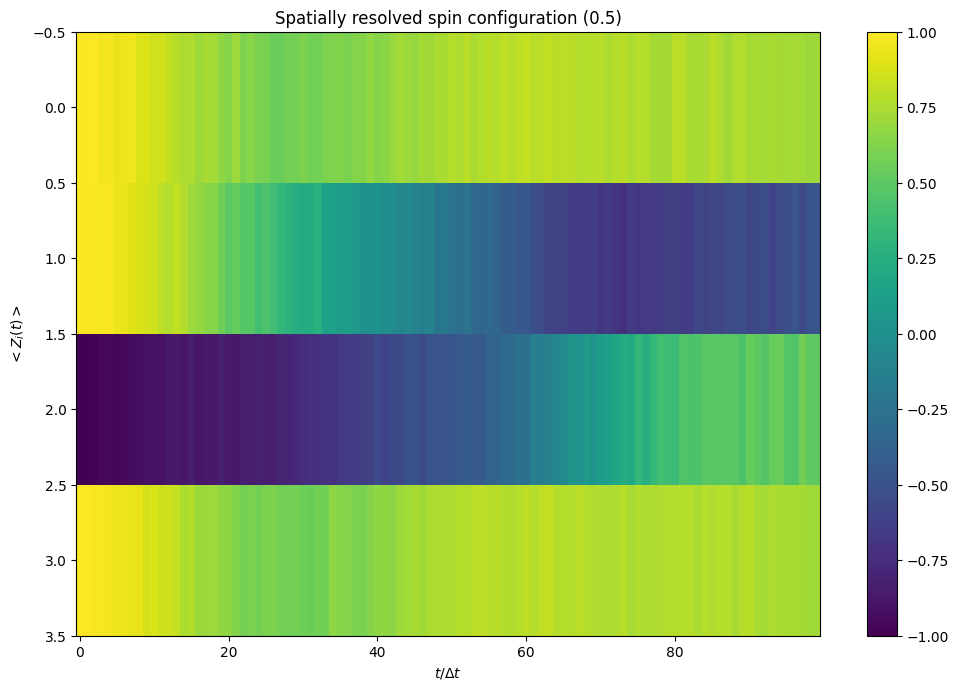

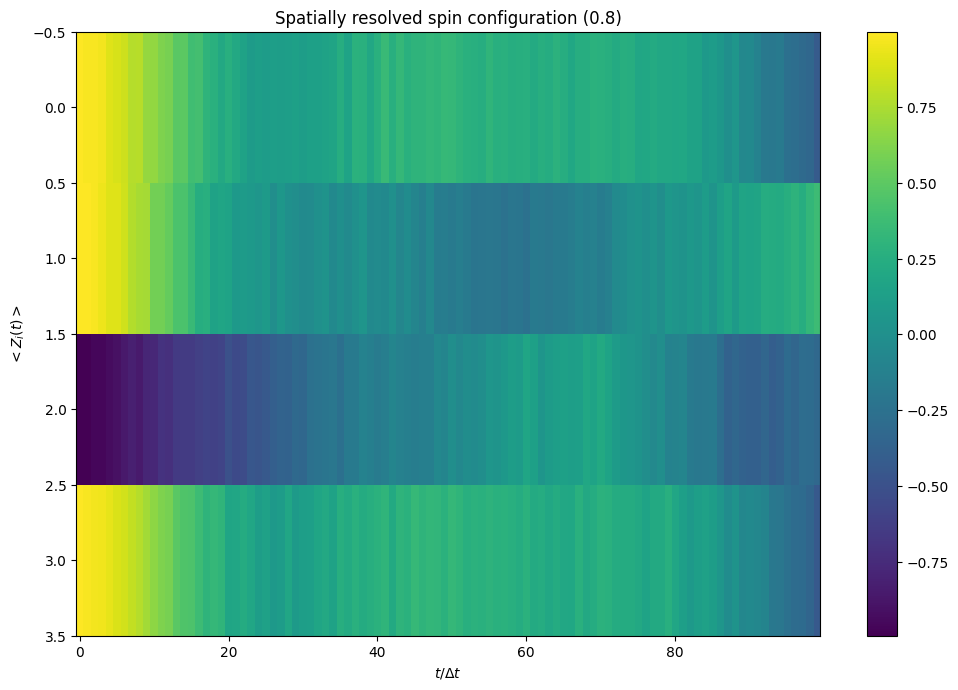

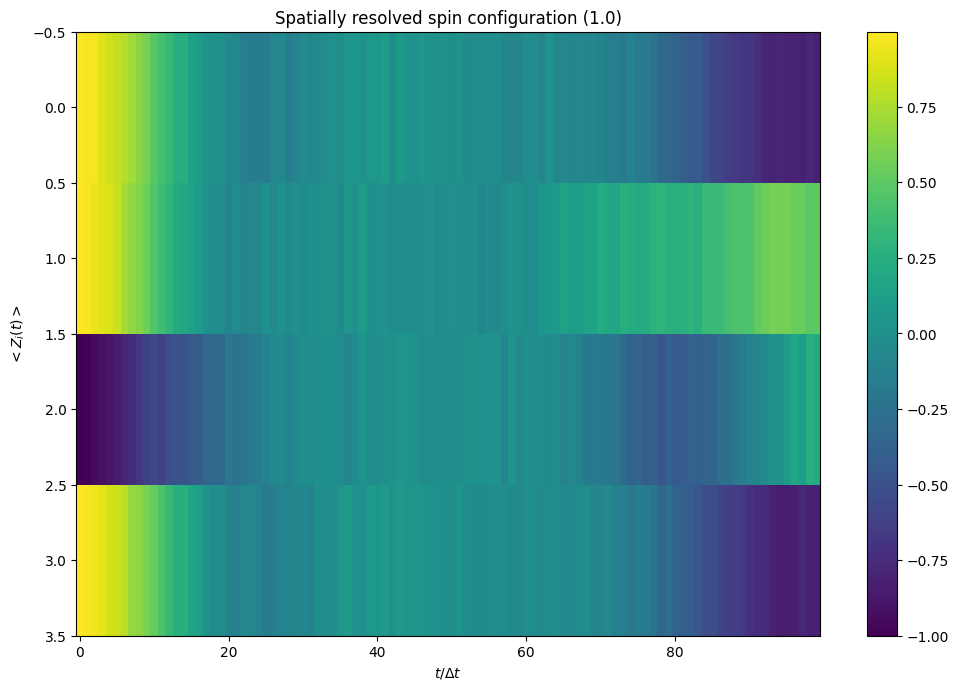

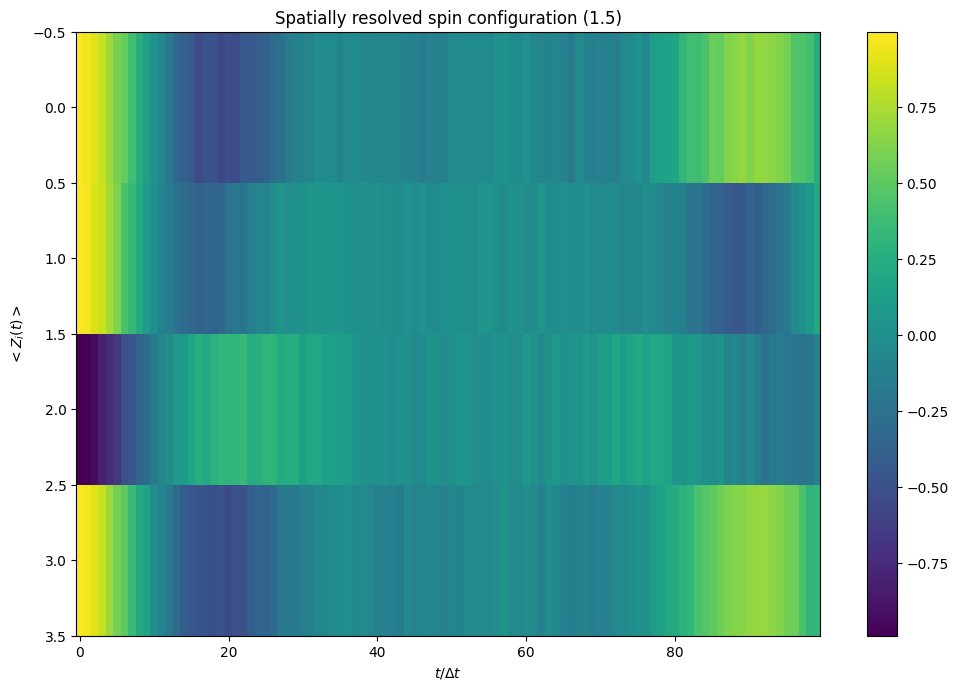

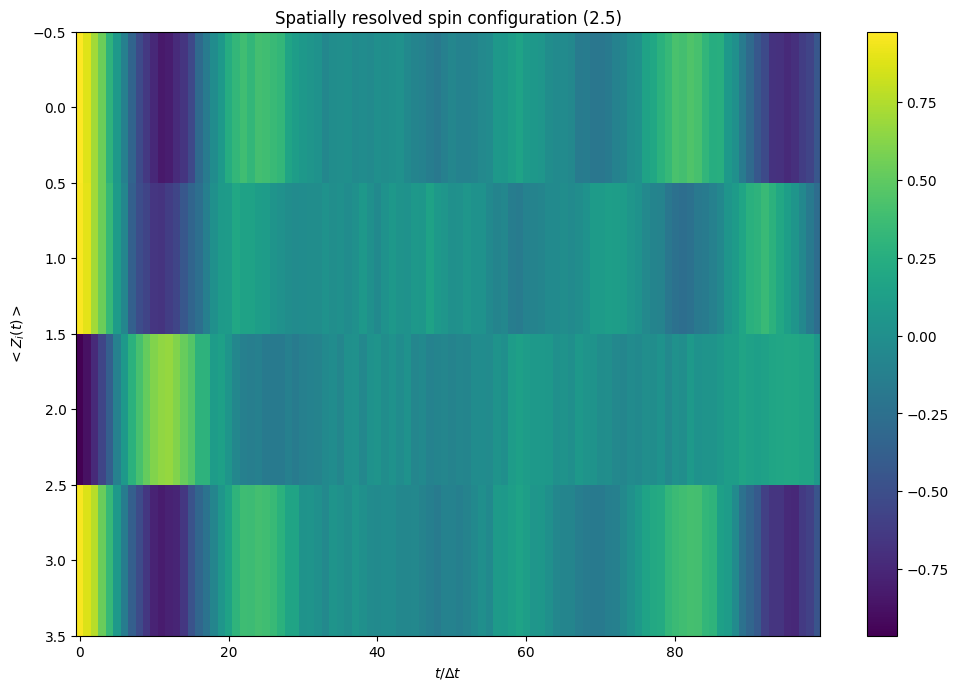

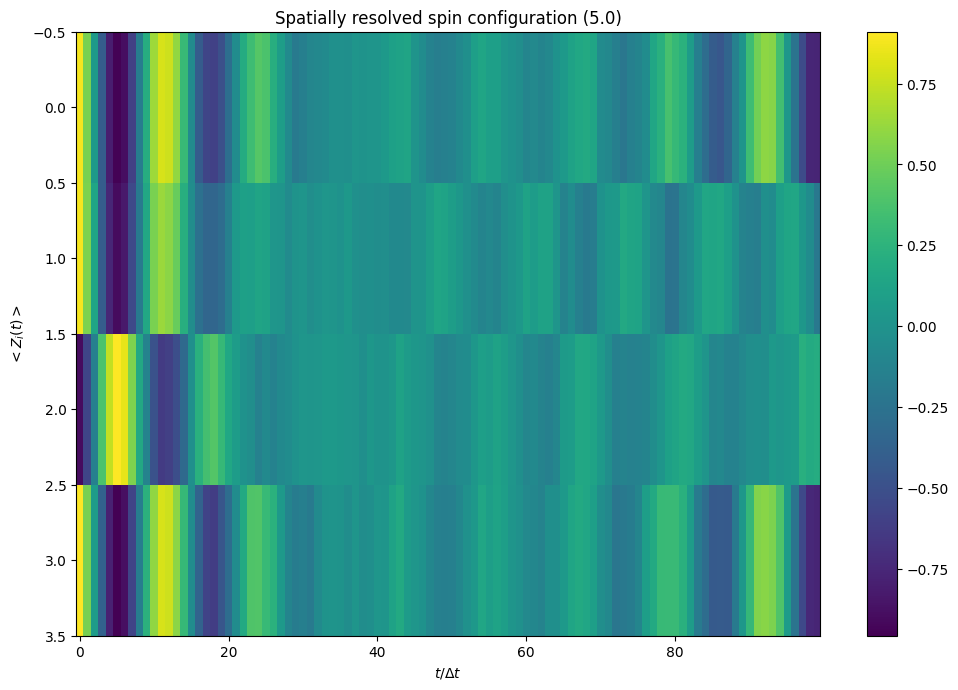

In [10]:
counts_vs_h = {}
mag_vs_h = {}

fieldstrengths = [0.1,0.5,0.8,1.,1.5,2.5,5.]
for h in fieldstrengths:
    results_per_step = simulate_time_evolution(h,timestep,nsteps,nshots,nqubits,initial_state,do_noise=False)
    counts_vs_h[h] = [results.get_counts() for results in results_per_step]
    mag_vs_h[h] = get_magnetization_with_solution(h,timestep,nsteps,nqubits,initial_state,counts_vs_h[h])

plot_magnetization(mag_vs_h)

In [12]:
results_vs_h_noisy = {}
counts_vs_h_noisy = {}
mag_vs_h_noisy = {}

for h in fieldstrengths:
    results_per_step = simulate_time_evolution(h,timestep,nsteps,nshots,nqubits,initial_state,do_noise=True)
    results_vs_h_noisy[h] = results_per_step
    counts_vs_h_noisy[h] = [results.get_counts() for results in results_per_step]
    mag_vs_h_noisy[h] = get_magnetization_with_solution(h,timestep,nsteps,nqubits,initial_state,counts_vs_h_noisy[h])

plot_magnetization(mag_vs_h_noisy)

NameError: name 'mag_vs_h_with_noise' is not defined

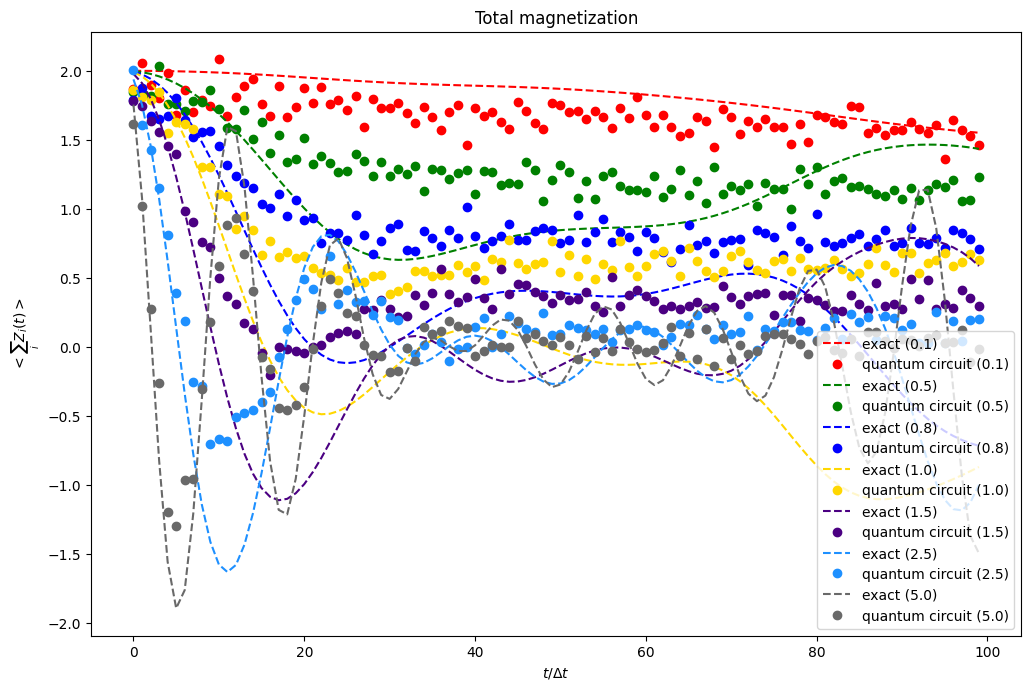

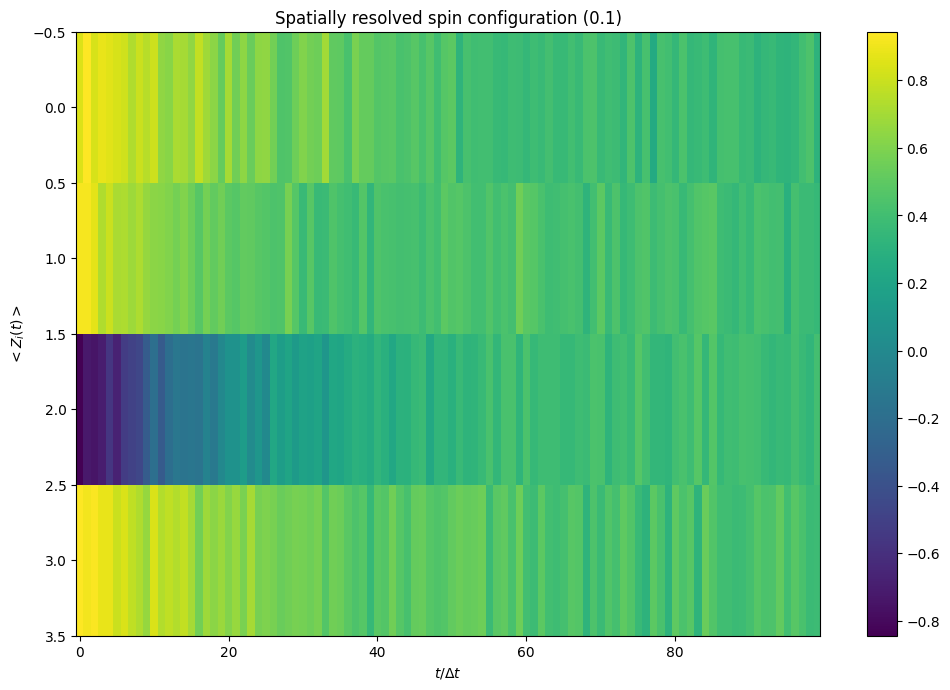

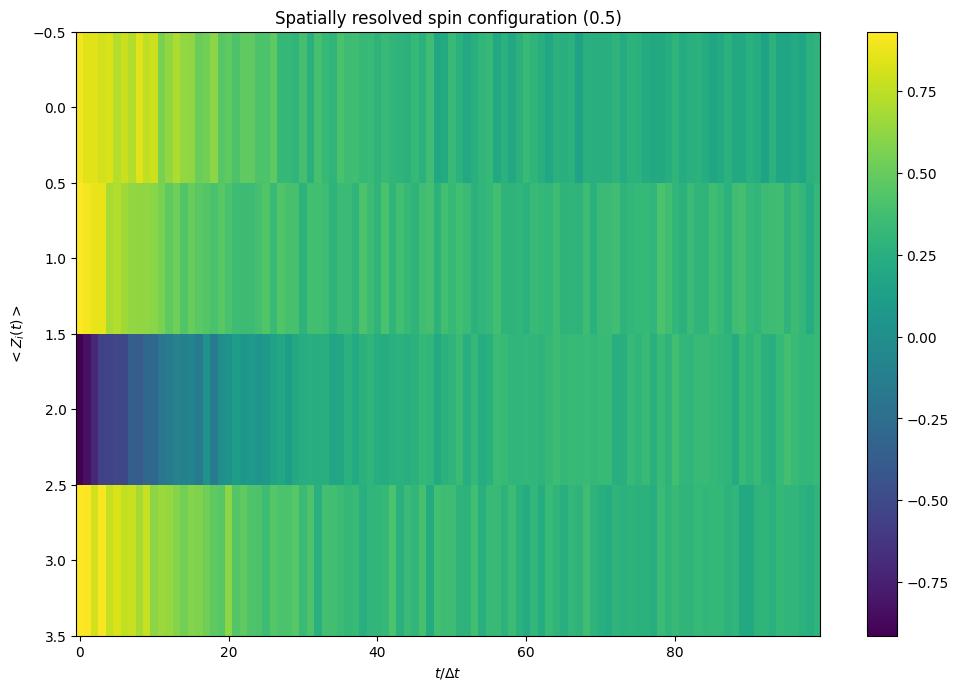

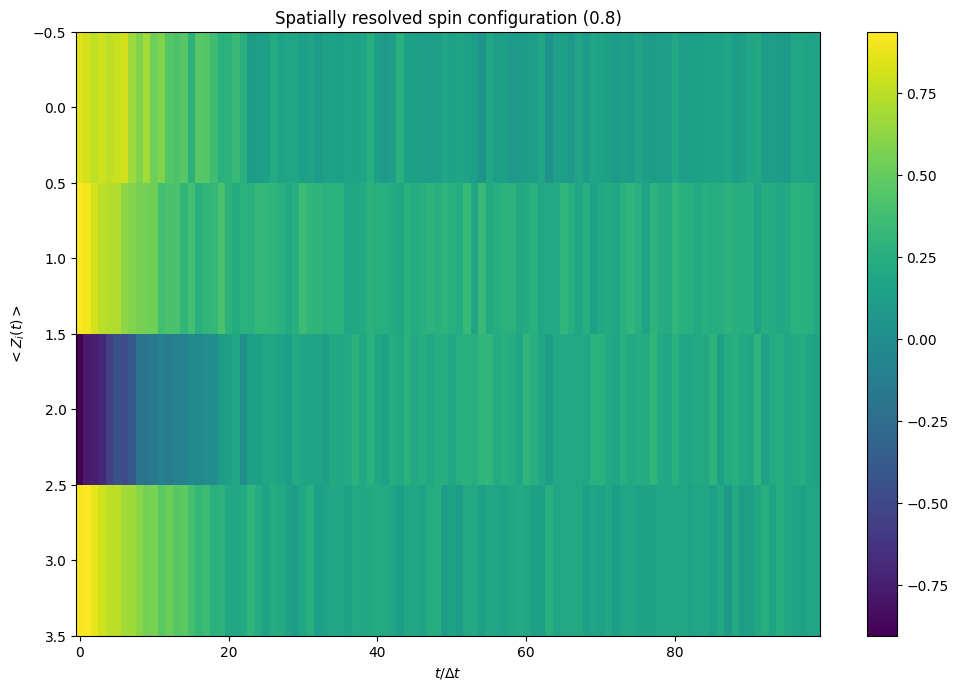

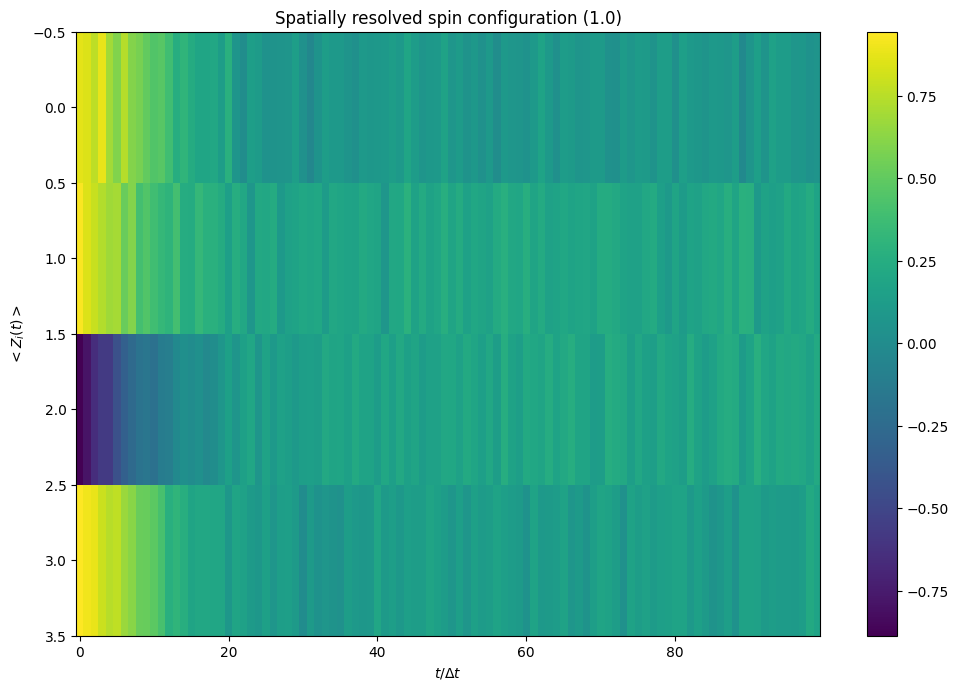

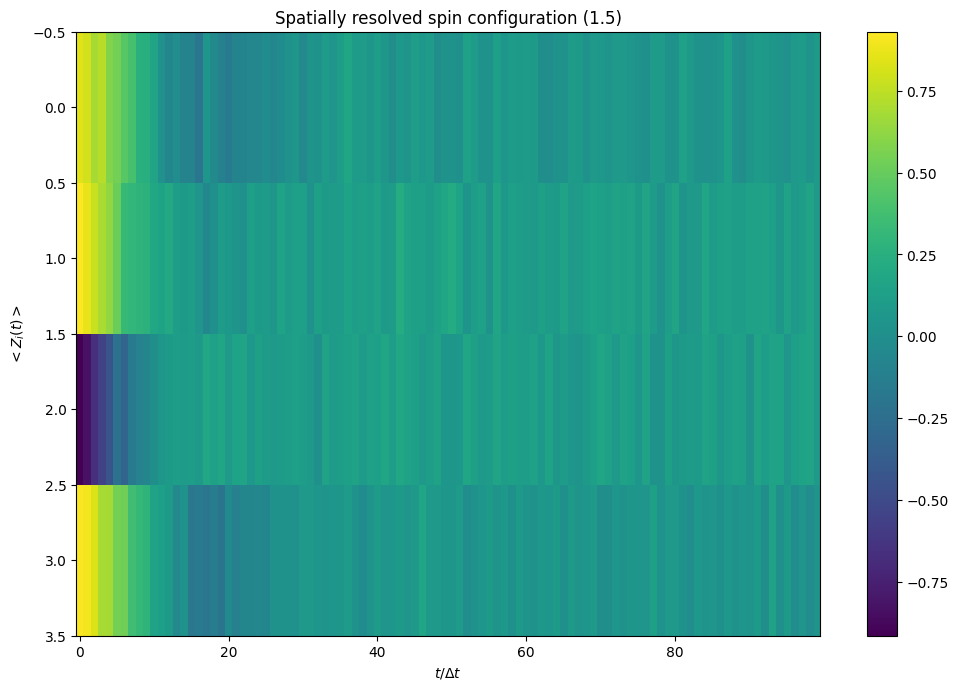

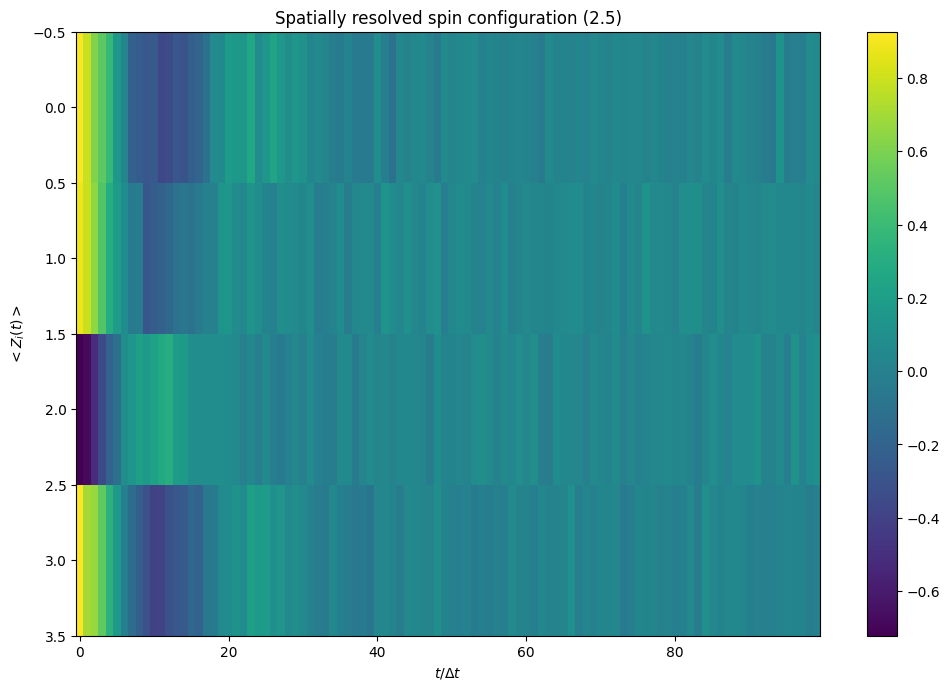

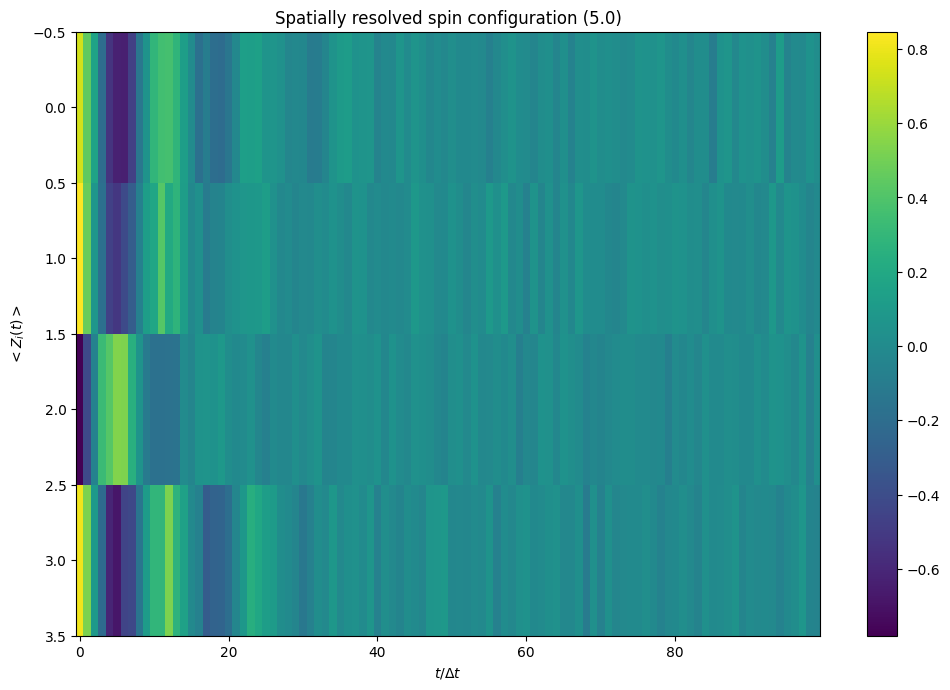

In [13]:
plot_magnetization(mag_vs_h_noisy)

In [32]:
# Generate a noise model reflecting the backend
from qiskit.providers.aer.noise import NoiseModel

# Define a function to plot and annotate 2D arrays
def plot_matrix(m):
    fig, ax = plt.subplots()
    ax.imshow(m,cmap=plt.get_cmap("autumn"))
    # axis labels
    axlabels = [f"{i:b}".zfill(m.shape[0]) for i in range(m.shape[0])]
    ax.set_xticks(np.arange(len(axlabels)))
    ax.set_yticks(np.arange(len(axlabels)))
    ax.set_xticklabels(axlabels)
    ax.set_yticklabels(axlabels)
    # bin labels
    for i in range(len(axlabels)):
        for j in range(len(axlabels)):
            text = ax.text(j, i, m[i,j],
                           ha="center", va="center", color="b")
    pass

def get_cal_measurement(nqubits):
    # Build a calibration circuit to measure the impact of noise
    from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
    qr = QuantumRegister(nqubits)
    meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

    # Simulate and get the result of passing measurement states through the device
    # This should reflect both bit-flips and gate errors, combining everything
    # effectively into a device folding matrix
    backend = get_backend(do_noise=True)

    t_qc = transpile(meas_calibs, backend)
    qobj = assemble(t_qc, shots=10000)
    simulator = AerSimulator.from_backend(backend)
    noise_model = NoiseModel.from_backend(backend)

    cal_results = simulator.run(qobj, noise_model=noise_model, shots=10000).result()

    # Show the extracted calibration matrix
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
    plot_matrix(meas_fitter.cal_matrix)
    return meas_fitter

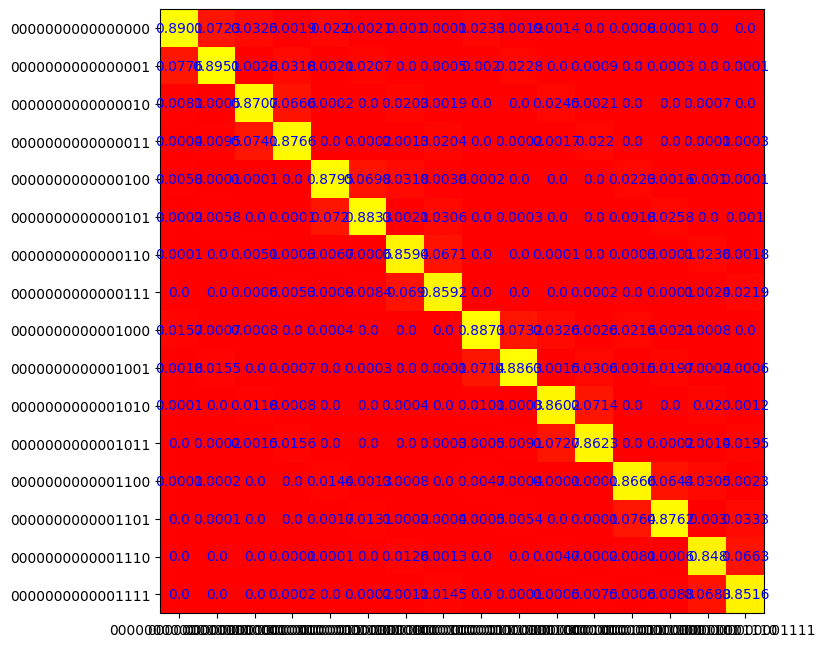

In [37]:
meas_fitter = get_cal_measurement(nqubits)
meas_filter = meas_fitter.filter

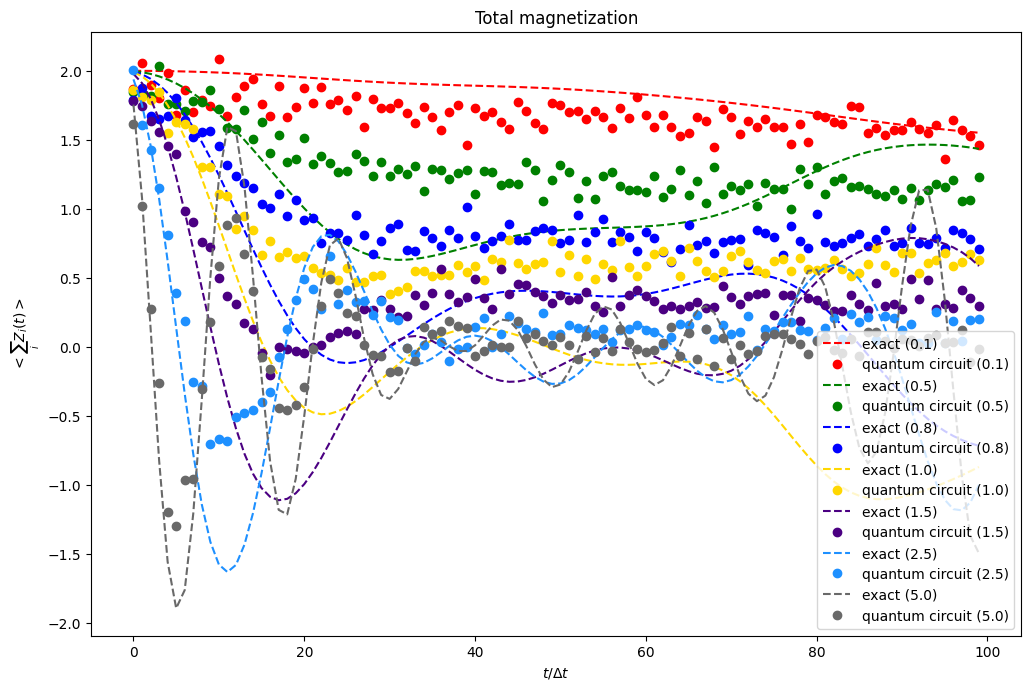

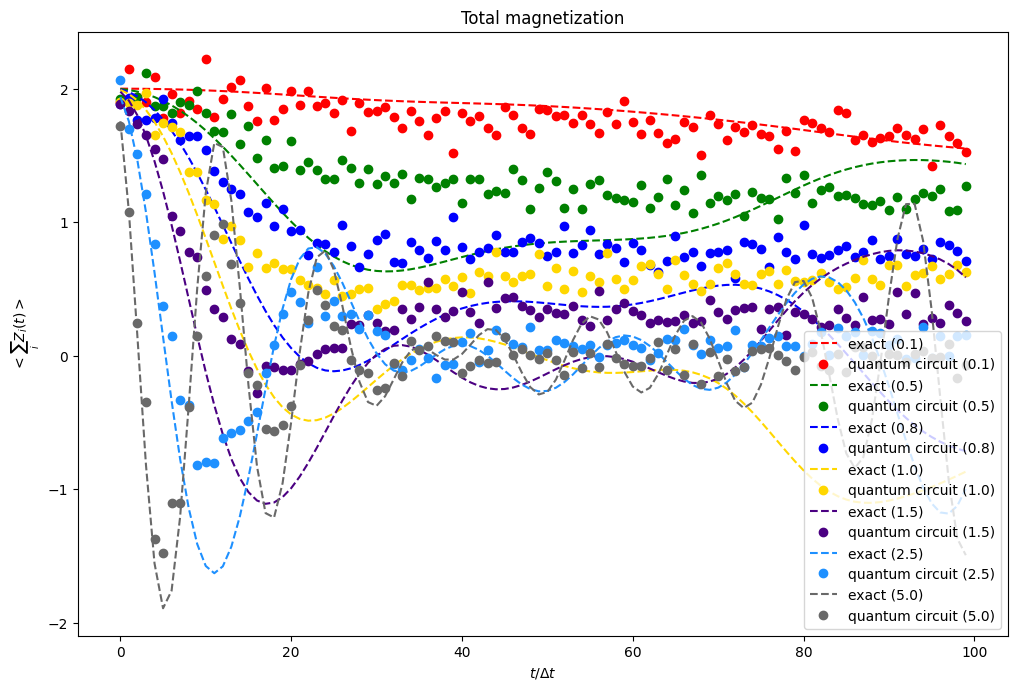

In [41]:
counts_vs_h_mitigated = {}
mag_vs_h_mitigated = {}

for h in fieldstrengths:
    counts_vs_h_mitigated[h] = [meas_filter.apply(results).get_counts() for results in results_vs_h_noisy[h]]
    mag_vs_h_mitigated[h] = get_magnetization_with_solution(h,timestep,nsteps,nqubits,initial_state,counts_vs_h_mitigated[h])

plot_magnetization(mag_vs_h_noisy,draw_configuration=False)
plot_magnetization(mag_vs_h_mitigated,draw_configuration=False)

In [39]:
counts_vs_h_noisy[0.1][50]

{'1011': 14,
 '1111': 13,
 '1101': 10,
 '0101': 29,
 '0111': 26,
 '1001': 28,
 '1010': 39,
 '0011': 43,
 '0001': 81,
 '0110': 54,
 '1100': 28,
 '0100': 75,
 '1110': 35,
 '1000': 87,
 '0010': 132,
 '0000': 306}

In [42]:
counts_vs_h_mitigated[0.1][50]

{'0000': 329.2132812760506,
 '0001': 58.71359538098604,
 '0010': 143.1940709667903,
 '0011': 35.12324569052245,
 '0100': 78.1131634426318,
 '0101': 24.710519248269236,
 '0110': 58.28291384306671,
 '0111': 24.537171415615937,
 '1000': 87.9317219965274,
 '1001': 22.0807250496953,
 '1010': 40.37436547681491,
 '1011': 11.317831662023792,
 '1100': 28.40825237460927,
 '1101': 7.629328370453745,
 '1110': 38.96114086430211,
 '1111': 11.408672941640315}

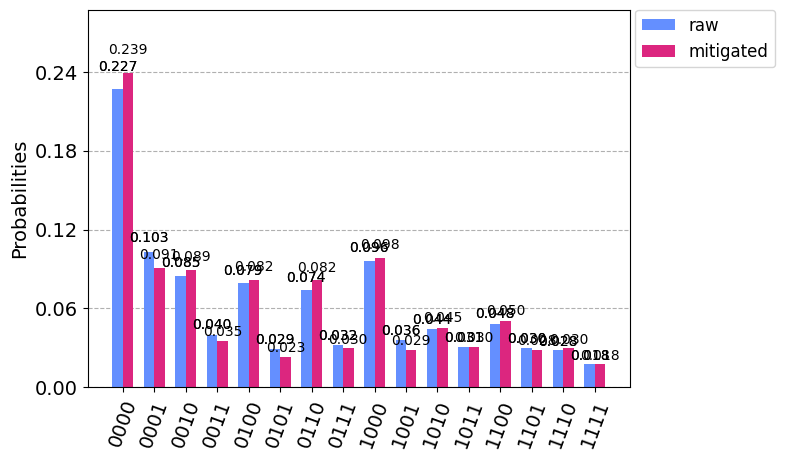

In [46]:
plot_histogram([counts_vs_h_noisy[0.5][50],counts_vs_h_mitigated[0.5][50]], legend=['raw', 'mitigated'])

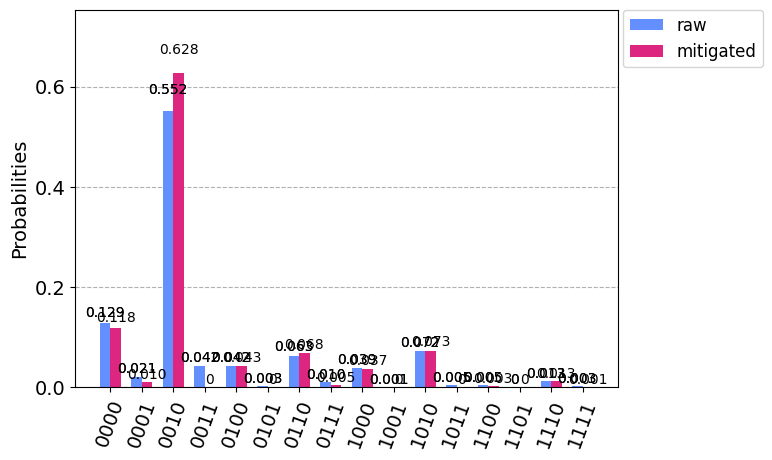

In [47]:
plot_histogram([counts_vs_h_noisy[0.5][5],counts_vs_h_mitigated[0.5][5]], legend=['raw', 'mitigated'])